In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# Step 1: Loading traditional Digit MNIST dataset

In [24]:
# I got error on downloading this dataset so I only use it online without downloading

#transform data into Tensor and normalize with mean = 0.5, standard deviation = 0.5 -> do lech chuan
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform= transform
)


training_data , valid_data = torch.utils.data.random_split(training_data , [0.8,  0.2], )

test_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform= transform
)

#after transform image become tensor and can only displayed using plt.imshow with img.squeeze()

In [25]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}


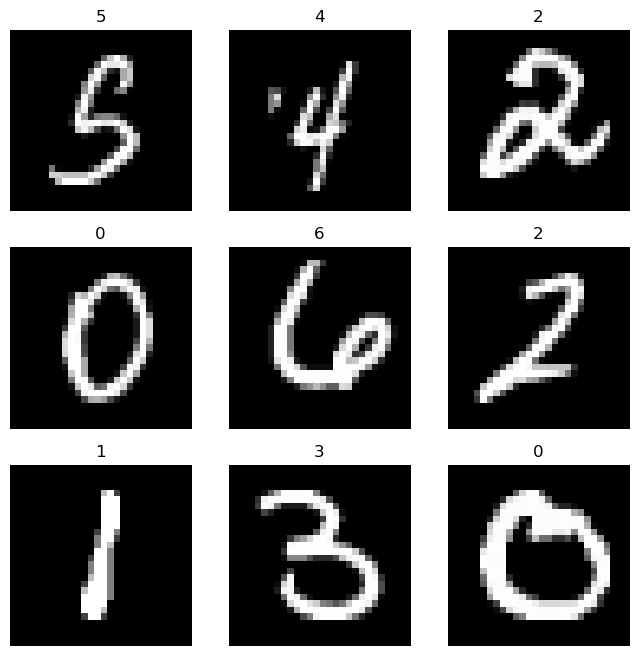

In [26]:
# using plt to show the numbers and labels randomly 

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img , label= training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") #in order to use plt.imshow , must use img.squeeze()
plt.show()

In [27]:
from torch.utils.data import DataLoader


epoch_num = 10
batch_size_train = 64
batch_size_test = 1000
l_r = 0.01
momentum = 0.9
#log_interval = 100  #how often the training result being printed (1 time for every 100 batches)

random_seed = 10
torch.manual_seed(random_seed)


In [28]:
# for shuffling the dataset when we sample a minibatch in the training phase 

train_dataloader = torch.utils.data.DataLoader(training_data , batch_size = batch_size_train , shuffle= True)
valid_dataloader = torch.utils.data.DataLoader(valid_data , batch_size= batch_size_test , shuffle= False)
test_dataloader = torch.utils.data.DataLoader(test_data , batch_size= batch_size_test, shuffle = False)


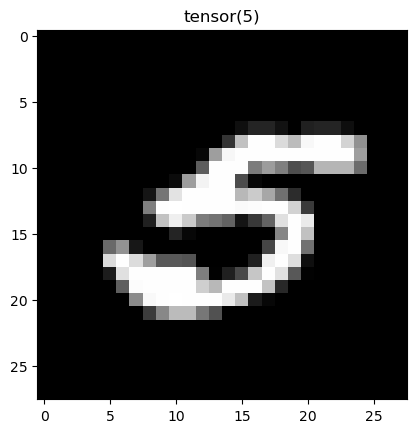

In [29]:
# to see a batch when DataLoader sampling, using next(iter(...)) #a batch is 64 figures size 1x28x28 and it's labels
train_features, train_labels = next(iter(train_dataloader))

img =  train_features[0].squeeze() 
label = train_labels[0]

plt.imshow(img , cmap = "gray")
plt.title(label)
plt.show()



# Step 2: Building CNN Lenet5 model 

In [30]:
# lenet activation function 
# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
#         self.fc1 = nn.Linear(16*5*5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)
#         self._initialize_weights()
    
#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.xavier_normal_(m.weight)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)
#             elif isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)
    
#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.max_pool2d(x, kernel_size=2, stride=2)
        # x = torch.relu(self.conv2(x))
        # x = torch.max_pool2d(x, kernel_size=2, stride=2)
        # x = x.view(-1, 16*5*5)
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x
    




In [31]:
#sigmoid function

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.sigmoid(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 16*5*5)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
import torch.optim as optim 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7 , gamma = 0.1)


# Step 3: Train the network 

In [33]:
num_epochs = 25
best_acc = 0

#currently SIGMOID
PATH = './lenet5_sigmoid_best.pth'
torch.save(model.state_dict(), PATH)
for epoch in range(num_epochs):

    for phase in ['train' , 'valid']:
        if phase == 'train':

            model.train()
            running_loss = 0.0
            
            for inputs, labels in train_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item()

            scheduler.step()
            
            
        elif phase == 'valid':
            model.eval()
            valid_loss = 0.0
            correct = 0
            total = 0 
            for inputs, labels in valid_dataloader:
                inputs , labels = inputs.to(device) , labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs , labels)
                valid_loss+= loss.item()
                _, predicted = torch.max(outputs.data, 1) #Gets the predicted class by finding the index of the maximum value in the output tensor along dimension 1
                
                for i in predicted:
                    if predicted[i] == labels[i]:
                        correct+=1

                total += labels.size(0)    
            percent_acc = 100*correct/total
            if percent_acc > best_acc:
                best_acc = percent_acc
                torch.save(model.state_dict , PATH)

    print(f'Epoch [{epoch + 1}/{num_epochs}], training loss: {running_loss / len(train_dataloader):.2f} , valid correct percent : {percent_acc:.2f}')




print('Finished Training')






Epoch [1/25], training loss: 2.31 , valid correct percent : 8.33
Epoch [2/25], training loss: 2.04 , valid correct percent : 60.98
Epoch [3/25], training loss: 0.79 , valid correct percent : 85.11
Epoch [4/25], training loss: 0.42 , valid correct percent : 90.88
Epoch [5/25], training loss: 0.30 , valid correct percent : 92.78
Epoch [6/25], training loss: 0.23 , valid correct percent : 94.06
Epoch [7/25], training loss: 0.19 , valid correct percent : 94.23
Epoch [8/25], training loss: 0.17 , valid correct percent : 94.91
Epoch [9/25], training loss: 0.16 , valid correct percent : 94.89
Epoch [10/25], training loss: 0.16 , valid correct percent : 94.89
Epoch [11/25], training loss: 0.16 , valid correct percent : 94.92
Epoch [12/25], training loss: 0.16 , valid correct percent : 94.92
Epoch [13/25], training loss: 0.15 , valid correct percent : 95.66
Epoch [14/25], training loss: 0.15 , valid correct percent : 94.90
Epoch [15/25], training loss: 0.15 , valid correct percent : 94.92
Epoch

In [34]:
# PATH = './lenet5_sigmoid.pth'
# torch.save(model.state_dict(), PATH)


In [35]:
# PATH = './lenet5_relu.pth'
# torch.save(model.state_dict() , PATH )

In [36]:
# Sigmoid activation function
# model = LeNet()
# model.load_state_dict(torch.load("./lenet5_sigmoid.pth" , weights_only= True))


In [37]:
# Relu activation function
# model = LeNet()
# model.load_state_dict(torch.load("./lenet5_relu.pth" ,weights_only= True))



In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() #use evaluation mode in order to stop using drop out
correct = 0
total = 0
with torch.no_grad(): #disable gradient calculating to saving memory
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device) #send to device to use cpu or gpu 
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #Gets the predicted class by finding the index of the maximum value in the output tensor along dimension 1
        total += labels.size(0)
        for i in predicted:
            if predicted[i] == labels[i]:
                correct+=1
        
print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')

Accuracy of the model on the 10000 test images: 95.89%
